In [97]:
import pandas as pd
from pandas import DataFrame
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import random

# Data cleaning

With this notebook, we'll be cleaning a dataset of audio features from music tracks downloaded from the Spotify API.

### a) Initial exploration

First, we'll look at the overall description of our dataset to see if any issues jump out.

In [98]:
tracks: DataFrame = pd.read_csv('data/audio_features_4.0.csv')
tracks = tracks.drop('id', axis=1)

In [99]:
tracks.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
count,916668.000000,916668.000000,916668.000000,916668.000000,916668.000000,916668.000000,916668.000000,916668.000000,916668.000000,916668.000000,916668.000000,9.166680e+05,916668.000000,222476.000000
mean,0.537007,0.654988,5.289780,-8.733212,0.638696,0.083720,0.283064,0.217647,0.201232,0.479339,122.323912,2.362498e+05,3.902495,33.901441
std,0.182291,0.258401,3.563508,5.241114,0.480379,0.104858,0.333119,0.343082,0.169247,0.271533,29.771911,1.182468e+05,0.421955,19.194924
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.053000e+03,0.000000,0.000000
25%,0.414000,0.483000,2.000000,-10.771000,0.000000,0.035900,0.005630,0.000002,0.096300,0.249000,99.836000,1.778270e+05,4.000000,20.000000
50%,0.547000,0.706000,5.000000,-7.438000,1.000000,0.048600,0.111000,0.001270,0.130000,0.470000,121.376000,2.183200e+05,4.000000,35.000000
75%,0.673000,0.875000,8.000000,-5.231000,1.000000,0.083800,0.531000,0.401000,0.265000,0.704000,140.039000,2.696930e+05,4.000000,48.000000
max,0.990000,1.000000,11.000000,5.842000,1.000000,0.968000,0.996000,1.000000,1.000000,1.000000,249.987000,5.676437e+06,5.000000,95.000000


In [100]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916668 entries, 0 to 916667
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      916668 non-null  float64
 1   energy            916668 non-null  float64
 2   key               916668 non-null  float64
 3   loudness          916668 non-null  float64
 4   mode              916668 non-null  float64
 5   speechiness       916668 non-null  float64
 6   acousticness      916668 non-null  float64
 7   instrumentalness  916668 non-null  float64
 8   liveness          916668 non-null  float64
 9   valence           916668 non-null  float64
 10  tempo             916668 non-null  float64
 11  duration_ms       916668 non-null  float64
 12  time_signature    916668 non-null  float64
 13  artist_name       916668 non-null  object 
 14  song_name         916667 non-null  object 
 15  genre             916668 non-null  object 
 16  spotify_track_id  91

In [101]:
print('Overall songs:', len(tracks))
print('Unique genres:', tracks.groupby(by='genre').count().spotify_track_id.count())
print('Mean songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.mean())
print('Median songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.median())
print('Min songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.min())
print('Max songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.max())

Overall songs: 916668
Unique genres: 132
Mean songs per genre: 6944.454545454545
Median songs per genre: 5776.5
Min songs per genre: 788
Max songs per genre: 19061


Overall, it looks like there are no null values, but some of the features have potential problems. Tempo and time_signature both go down to zero, which doesn't make sense musically. (Note: Loudness has a negative value because decibels are reported relative to a reference value.)

Let's look at how many tempo and time_signature values are zero or near-zero.

In [102]:
print('Tempo below 10:', tracks[tracks.tempo < 10].count().tempo)
print('Tempo at 0:', tracks[tracks.tempo == 0].count().tempo)
print('Time_signature below 1:', tracks[tracks.time_signature < 1].count().time_signature)
print('Time_signature at 0:', tracks[tracks.time_signature == 0].count().time_signature)

Tempo below 10: 444
Tempo at 0: 444
Time_signature below 1: 454
Time_signature at 0: 454


In [103]:
tempo_mask = tracks.tempo < 10
time_mask = tracks.time_signature < 1
tracks[tempo_mask | time_mask].sample()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,song_name,genre,spotify_track_id,popularity
565969,0.0,0.135,6.0,-15.679,1.0,0.0,0.955,0.0,0.232,0.0,0.0,116133.0,0.0,Metropolitan Opera Orchestra,La donne è mobile from Rigoletto - Vocal,Opera,4DuBvJTHb89u1hjUyX2j5D,NaN


Almost all the tracks that have zero tempo or time_signature have zero values for both. Furthermore, there are only a small number of rows with either of these features equal to zero. Because this is likely bad data, we will drop these rows.

In [104]:
tracks = tracks[~(tempo_mask | time_mask)]

### b) Duplicates

Next we will look at duplicates. Because we downloaded top artists by genre and top tracks by artist, there might be some overlap, with some tracks in multiple genres or associated with multiple artists. 

To simplify things, let's start by looking at the tracks that have every characteristic in common. After we tackle this problem, we can worry about songs that are similar, but have one or two attributes (like artist name or genre) listed differently.

In [105]:
print('Percent of rows with duplicates for all features:', len(tracks[tracks.duplicated()]) / len(tracks))

Percent of rows with duplicates for all features: 0.19468377475131357


We'll go ahead and drop these rows, which are redundant.

In [106]:
print('Datapoints before drop:', len(tracks))
tracks = tracks[~tracks.duplicated()]
print('Datapoints after drop:', len(tracks))

Datapoints before drop: 916214
Datapoints after drop: 737842


Next, we'll look at songs with duplicate Spotify song ID and name in the dataset.

In [107]:
track_id_dup = tracks.spotify_track_id.duplicated()
song_name_dup = tracks.song_name.duplicated()

print('Percent duplicate name and unique ID:', len(tracks[~track_id_dup & song_name_dup]) / len(tracks))
print('Percent duplicate ID and unique name:', len(tracks[track_id_dup & ~song_name_dup]) / len(tracks))
print('Percent duplicate ID and name:', len(tracks[track_id_dup & song_name_dup]) / len(tracks))

Percent duplicate name and unique ID: 0.1687054952144226
Percent duplicate ID and unique name: 0.0
Percent duplicate ID and name: 0.25418314490094085


There are no songs with the same ID and different names. Start by investigating songs with duplicate names but unique IDs.

In [108]:
WINDOW_SIZE = 4
random_center = random.randint(WINDOW_SIZE / 2, len(tracks[~track_id_dup & song_name_dup]) - WINDOW_SIZE / 2)
tracks[~track_id_dup & song_name_dup].sort_values(by='song_name')[random_center - WINDOW_SIZE:random_center + WINDOW_SIZE]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,song_name,genre,spotify_track_id,popularity
243028,0.630,0.424,2.0,-11.856,0.0,0.0337,0.75000,0.0231,0.1130,0.288,141.988,194069.0,4.0,Jessie Reid,Give Me Love,Indie Folk,2WzRv2VUsN3673wKYSUkVD,NaN
743068,0.443,0.974,7.0,-5.309,1.0,0.0723,0.00196,0.0323,0.0470,0.264,108.578,252325.0,5.0,Fracture,Give Me Love,Dubstep,5CPR0iMBDViehrH9jV5Ixk,NaN
656184,0.741,0.919,9.0,-1.338,0.0,0.0788,0.04070,0.6020,0.1620,0.377,160.044,266202.0,4.0,Grandtheft,Give Me More,Electronic,5WtKSBI21sZmwRHAEe7uTp,NaN
500836,0.586,0.227,11.0,-12.444,0.0,0.0652,0.97900,0.0000,0.1370,0.749,146.458,175587.0,4.0,Son Bonds,Give Me That Old Time Religion,Country Blues,3vPufpQrkyqcstJJ8aWrq0,NaN
891419,0.730,0.717,0.0,-10.308,1.0,0.0425,0.61900,0.0000,0.3060,0.964,109.413,87769.0,4.0,Smokey Mountain Gospel Singers,Give Me That Old-Time Religion,Gospel,7DQlbuCa6d9UEYgMV8yg7i,NaN
151802,0.716,0.133,0.0,-15.846,1.0,0.0421,0.87900,0.0000,0.0966,0.551,62.140,140520.0,3.0,Lorez Alexandria,Give Me The Simple Life,Jazz,7Kc3hZoCRTs5dNHU7GqT9x,58.0
915318,0.682,0.330,9.0,-11.931,0.0,0.0724,0.86900,0.0000,0.4380,0.780,129.226,160933.0,4.0,Somethin' Smith & The Redheads,Give Me The Simple Life,Adult Standards,3ybxHZHWlWZ8N7rpHVzQXY,NaN
195731,0.635,0.829,9.0,-11.524,0.0,0.0581,0.00149,0.0111,0.1840,0.613,118.207,367333.0,4.0,Shannon,Give Me Tonight,Disco,7B5Hc4wRrbXtPOcxXRarX0,42.0


By sampling our dataset, we can see that there are common names that are used by different songs (like "I Want You" and "Aftermath"). It appears that these are mostly not duplicate songs, and so we won't drop them for now. 

A separate issue is songs that have both a duplicate ID and song name. Let's look at a selection of those data points.

In [109]:
tracks[track_id_dup & song_name_dup].sort_values(by='spotify_track_id')[100:110]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,song_name,genre,spotify_track_id,popularity
681383,0.347,0.795,0.0,-7.130,1.0,0.0374,0.051400,0.000000,0.2570,0.926,204.218,128813.0,4.0,Black Lips,Bad Kids,Blues,00FL5d6IDB4Q6VROycdzOP,50.0
567010,0.577,0.725,0.0,-7.693,0.0,0.0440,0.105000,0.849000,0.0896,0.178,89.944,373583.0,4.0,Tarja,The Sleeping Indian,Opera,00GI6pa0noyUxlLL84GQiI,NaN
654313,0.951,0.567,10.0,-10.948,0.0,0.2830,0.446000,0.138000,0.1060,0.676,107.007,329719.0,4.0,Nicola Cruz,Danza de Vision,Electronic,00GwxMge3vIOMeV43Erckc,45.0
500938,0.664,0.216,11.0,-11.858,1.0,0.0429,0.972000,0.117000,0.1220,0.243,105.894,170453.0,4.0,The Mississippi Moaner,It's Cold In China Blues,Country Blues,00HJ2wdCkN4KoGt209l5H9,NaN
444786,0.231,0.927,11.0,-10.237,0.0,0.1550,0.000519,0.000025,0.1100,0.536,184.972,108880.0,4.0,Alternative Ulster,Drunk as Fuck,Celtic,00HKqRyW11heKaxfcJa9sp,NaN
772737,0.676,0.742,8.0,-5.017,1.0,0.1620,0.561000,0.000000,0.1550,0.694,77.071,165340.0,4.0,j-hope,Safety Zone,K-pop,00I41xsW6SunZDJ5fB8KAd,NaN
407681,0.326,0.962,9.0,-5.681,1.0,0.0906,0.000789,0.072500,0.3780,0.450,95.306,113360.0,4.0,Sick Of It All,Good Lookin' Out,Ska,00IV3r2AVGAjHEsTw79nTT,NaN
559333,0.326,0.962,9.0,-5.681,1.0,0.0906,0.000789,0.072500,0.3780,0.450,95.306,113360.0,4.0,Sick Of It All,Good Lookin' Out,Punk,00IV3r2AVGAjHEsTw79nTT,NaN
107672,0.826,0.713,9.0,-4.017,0.0,0.1290,0.074800,0.000000,0.3310,0.750,102.071,226739.0,4.0,Reykon,Latina (feat. Maluma),Latin Pop,00Ia46AgCNfnXjzgH8PIKH,NaN
17987,0.826,0.713,9.0,-4.017,0.0,0.1290,0.074800,0.000000,0.3310,0.750,102.071,226739.0,4.0,Reykon,Latina (feat. Maluma),Latin,00Ia46AgCNfnXjzgH8PIKH,NaN


Most of these songs with duplicate names and Spotify IDs are either cross-listed under various artists or various genres. For these songs, we'll drop the rows with different versions of the same track. This loses some data, but avoids the complication of classifying a song into multiple genres, which we don't have data for in the majority of cases. This approach allows our model to learn from each song, while also limiting the complexity for our initial modeling.

In [110]:
print('Datapoints before drop:', len(tracks))
tracks = tracks.drop_duplicates(subset=['spotify_track_id', 'song_name'])
print('Datapoints after drop:', len(tracks))

Datapoints before drop: 737842
Datapoints after drop: 550295


In [111]:
track_id_dup = tracks.spotify_track_id.duplicated()
song_name_dup = tracks.song_name.duplicated()

print('Percent duplicate name and unique ID:', len(tracks[~track_id_dup & song_name_dup]) / len(tracks))
print('Percent duplicate ID and unique name:', len(tracks[track_id_dup & ~song_name_dup]) / len(tracks))
print('Percent duplicate ID and name:', len(tracks[track_id_dup & song_name_dup]) / len(tracks))

Percent duplicate name and unique ID: 0.22620230967026778
Percent duplicate ID and unique name: 0.0
Percent duplicate ID and name: 0.0


### c) Outliers

Let's see what other outliers might be in our data using boxplots and Inter-Quartile Range. We'll be able to see datapoints that fall more than 1.5 times IQR away from the mean. This will suggest additional outliers. 

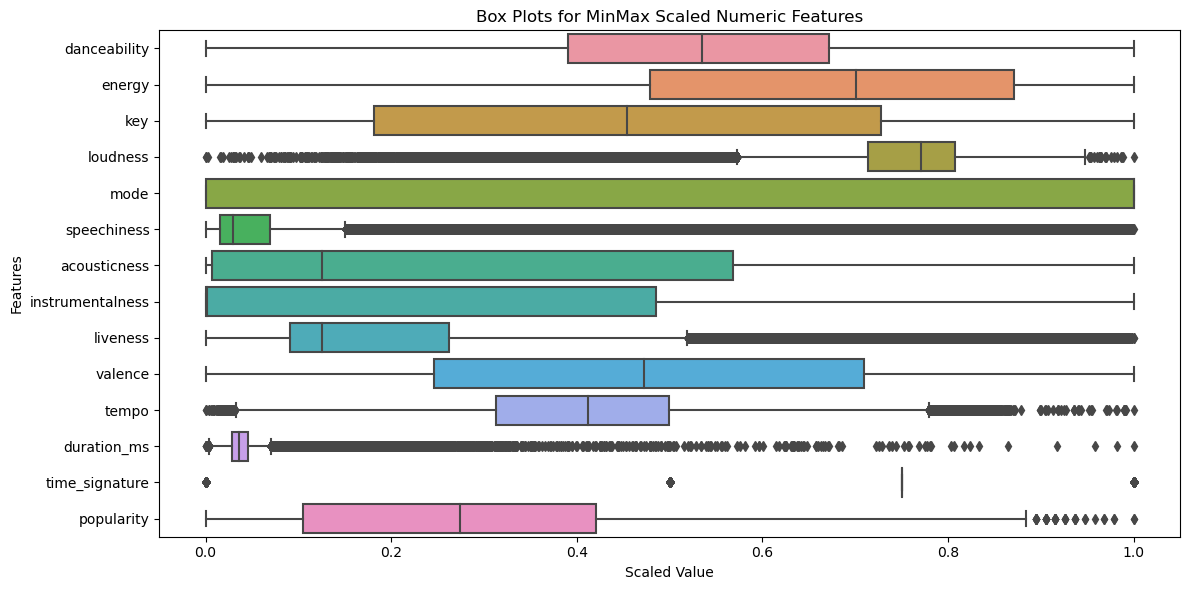

In [112]:
numeric_cols = [col for col in tracks.columns if pd.api.types.is_numeric_dtype(tracks[col])]
boxplot_tracks = tracks[numeric_cols]

# Scale the features using MinMaxScaler for visualization purposes
scaled_data = MinMaxScaler().fit_transform(boxplot_tracks)
boxplot_tracks_scaled = pd.DataFrame(scaled_data, columns=boxplot_tracks.columns)

# Plot box plots for each feature
plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_tracks_scaled, orient='h')
plt.title('Box Plots for MinMax Scaled Numeric Features')
plt.xlabel('Scaled Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

It looks like there are significant numbers of outliers as defined by IQR. Let's make a pairplot to check the distribution of each feature that had outliers. 

We'll leave out time_signature, because this data all falls into the range 1-5, and we can't reasonably classify a song in an abnormal time signature as an outlier.

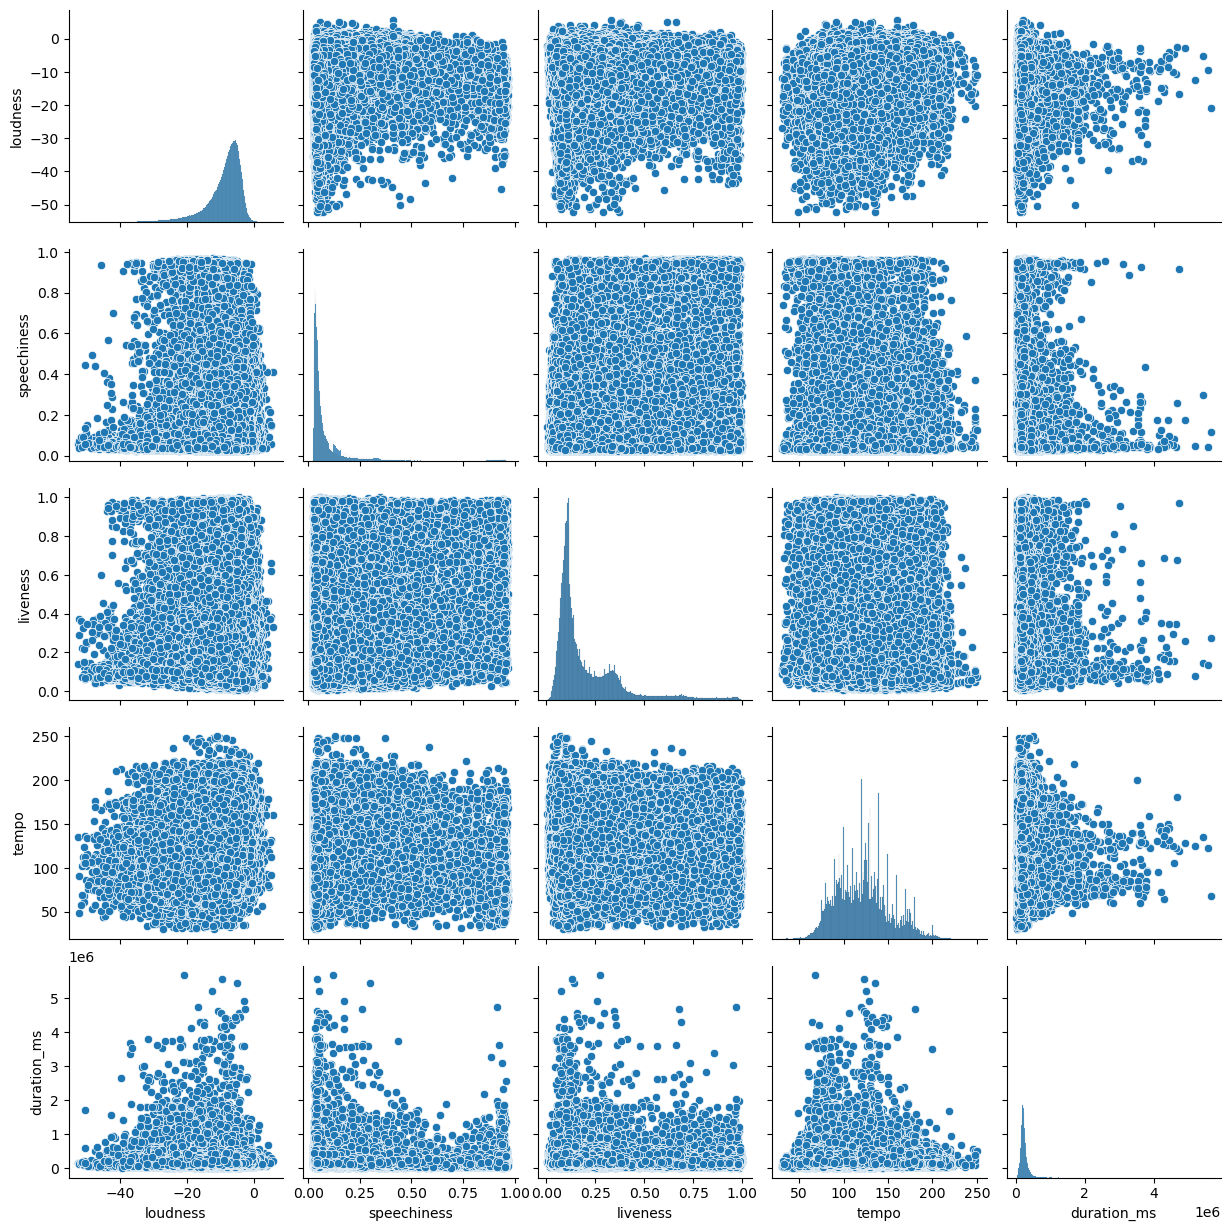

In [113]:
sns.pairplot(tracks.loc[:, ['loudness', 'speechiness', 'liveness', 'tempo', 'duration_ms']])
plt.show()

Loudness, speechiness, and liveness are all skewed with high kurtosis, with loudness being skewed towards 0 (indicating proximity to Spotify's decibel threshold), and speechiness and liveness being skewed towards 0. This distribution helps explain the high number of outliers captured by the boxplot, which is looking at a symmetric range around the median.

In the context of our data, this makes some sense. Spotify adjusts audio volume, and it makes sense that they wouldn't want music that's too quiet, or music above their decibel threshold. 

It also make some sense that liveness would cluster around zero, as most music is studio-recorded rather than live-recorded. 

For speechiness, which measures how much spoken (rather than sung or instrumental) sound there is in a track, it seems plausible that most tracks just don't qualify as speechy.

Next, we'll take a look at the distribution of outliers per row and explore the characteristics of the rows with a high concentration of outliers in one place.

In [114]:
# Calculate the lower and upper bound for each column
Q1 = tracks.quantile(0.25)
Q3 = tracks.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers in each row
outliers_mask = (tracks < lower_bound) | (tracks > upper_bound)

# Count the number of outliers per row
outliers_per_row = outliers_mask.sum(axis=1)

# Filter rows with at least one outlier
rows_with_outliers = outliers_per_row[outliers_per_row > 0]

# Analyze the distribution of outliers-per-row
outliers_distribution = rows_with_outliers.value_counts().sort_index()
print(outliers_distribution)

C:\Users\jackv\AppData\Local\Temp\ipykernel_2548\2314039613.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_mask = (tracks < lower_bound) | (tracks > upper_bound)


1    137953
2     32553
3      6278
4       616
5        45
dtype: int64


Once we start looking at rows with 4-5 outliers, there aren't many matching data points. Let's look at a sample of these rows and listen to some of the songs as a sanity check.

In [115]:
# Identify the outliers in each row
outliers_mask = (tracks < lower_bound) | (tracks > upper_bound)

outliers_per_row = outliers_mask.sum(axis=1)
rows_with_outliers = outliers_per_row[outliers_per_row > 0]
outliers_groups = rows_with_outliers.groupby(rows_with_outliers).groups

# Sample rows from each category
sample_size = 3  
random_seed = 538  
rng = np.random.default_rng(random_seed)

for num_outliers, row_indices in outliers_groups.items():
    sample_indices = rng.choice(row_indices, size=min(sample_size, len(row_indices)), replace=False)
    sampled_rows = tracks.loc[sample_indices]
    print(f"Sample rows with {num_outliers} outliers:")
    print(sampled_rows)

C:\Users\jackv\AppData\Local\Temp\ipykernel_2548\3253434263.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_mask = (tracks < lower_bound) | (tracks > upper_bound)


Sample rows with 1 outliers:
        danceability  energy  key  loudness  mode  speechiness  acousticness  \
408535         0.416   0.726  2.0    -7.611   1.0       0.0624       0.02200   
93149          0.602   0.940  5.0    -2.155   0.0       0.1930       0.00238   
121717         0.821   0.992  0.0    -3.109   1.0       0.2890       0.01480   

        instrumentalness  liveness  valence    tempo  duration_ms  \
408535          0.000118    0.0432    0.361  104.198      93444.0   
93149           0.074400    0.1560    0.244  169.992     320471.0   
121717          0.000313    0.3380    0.711  140.014     212786.0   

        time_signature artist_name                            song_name  \
408535             3.0   Joystick!                          Alcoholiday   
93149              4.0       Hixxy  Superhuman - Technikore & JTS Remix   
121717             4.0   แตงค์กิ้ว        รักมั้ย...พูด (Love love me?)   

           genre        spotify_track_id  popularity  
408535       Ska 

Sample songs with 5 outliers:

- Egg Babies by Bil Lepp. This is a recording of a stand-up performance. Highly live, long, speechy, quiet, and low tempo.
- Deep Stare by STL. This is a Dub Techno track, and it makes heavily use of nature sounds. It is quiet, over 7 minutes, low tempo, and has essentially no speech. The sound of leaves rustling sound a lot like a croud clapping, so this may be the reason for the high liveness score (Spotify uses crowd noise to measure liveness.)

Many of the other songs with a high degree of outliers are comedy shows, audiobooks, and similar recordings. These are not bad data, just different than the majority of the tracks, which are songs.

Are some genres identified consistently as outliers? Let's quickly explore this.

In [116]:
for col in ['loudness', 'speechiness', 'liveness', 'tempo', 'duration_ms']:
    outliers_mask = (tracks[col] < lower_bound[col]) | (tracks[col] > upper_bound[col])
    outliers = tracks[outliers_mask]
    genre_distribution = outliers['genre'].value_counts()
    print(f"Genre distribution for outliers in {col}:")
    print(genre_distribution[:50], '\n') 
    

Genre distribution for outliers in loudness:
Baroque              4336
Classical            3150
Soundtrack           2640
Ambient              2585
Opera                1876
Rai                  1645
New Age              1407
Avant-garde          1396
Orchestral           1385
Experimental         1073
Jazz                 1012
Comedy                620
Jazz Fusion           507
Industrial            386
Celtic                371
Techno                312
Indie Folk            265
Swing                 208
Bossa Nova            189
Singer-songwriter     170
Psychedelic Rock      170
Progressive Rock      169
Cabaret               161
Shoegaze              154
Quebecois             148
Classic Rock          133
Latin                 131
Flamenco              127
Bluegrass             122
Contemporary Folk     121
Folk                  120
Progressive Metal     118
J-pop                 116
Samba                 111
Electronic            111
Indie Pop             109
Adult Standards    

This check seems to provide further evidence that our outliers are good data.

For loudness, the majority of outliers are classical, ambient, or traditional music. 

For speechiness, we have lots of Guidance, Comedy, and Hip Hop.

For liveness, we have comedy, Gospel, German Show Tunes, Hoerspiel (German radio drama), and Environmental music (which seems to be often misclassified as live).

For tempo, we have genres like Dixieland, Accordian, and Cajun. A cursory listen suggests that these genres are indeed high tempo, although this category seems less clear-cut. (Overall, tempo has by far the fewest outliers of the five features, which decreases the importance of making a determination here.)

For duation_ms, the outliers are gernes like Progressive House, Goa Trance, and Deep Psytrance, which makes perfect sense.

Overall, based on our various investigations it looks like our outliers are not bad data, so we won't drop them.

### d) Final summary before export

Before we export, let's check to see the distribution of genres. We requested the top ten songs of the first 50 artists to appear in search for each genre, but some genres didn't have that many artists available.

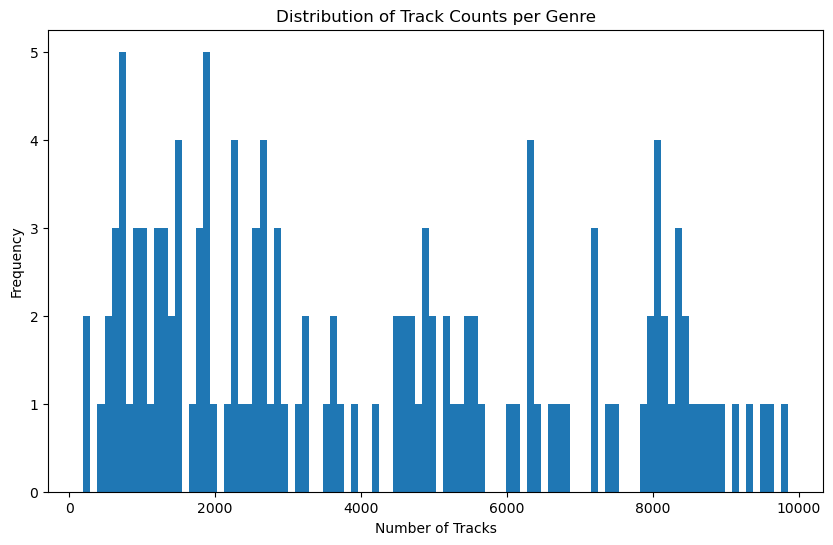

In [117]:
genre_counts = tracks.groupby(by='genre').size().sort_values(ascending=True)

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(genre_counts, bins=100)
plt.xlabel('Number of Tracks')
plt.ylabel('Frequency')
plt.title('Distribution of Track Counts per Genre')
plt.show()

Our tracks are clustered towards the genres we requested, but there is a non-trivial number of genres without much representation. Let's get a more precise picture by looking at the track counts per genre, sorted by tracks-per-genre.

In [118]:
tracks.groupby(by='genre').size().sort_values(ascending=True).head(20)

genre
Funk Rock         196
Madchester        251
Skiffle           399
Art Rock          541
Glam Rock         577
Acid House        603
Cowpunk           659
Acid Jazz         664
Dark Wave         684
Electroclash      692
Calypso           698
Country Blues     707
Dance-punk        707
Funky Breaks      859
Shibuya-kei       882
Hiplife           913
Mambo             964
Chiptune          991
Delta Blues      1029
Rock             1033
dtype: int64

And finally, we'll get an overall summary of our dataset after cleaning. The number of songs has reduced significantly, but there is still decent representation in most genres.

In [119]:
print('Overall songs:', len(tracks))
print('Unique genres:', tracks.groupby(by='genre').count().spotify_track_id.count())
print('Mean songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.mean())
print('Median songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.median())
print('Min songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.min())
print('Max songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.max())

Overall songs: 550295
Unique genres: 132
Mean songs per genre: 4168.901515151515
Median songs per genre: 3557.0
Min songs per genre: 196
Max songs per genre: 9851


### Export clean dataset

In [120]:
tracks.to_csv('data/audio_features_4.0_clean.csv', index=False)

# References

- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
- https://pandas.pydata.org/docs/reference/api/pandas.api.types.is_string_dtype.html
- https://seaborn.pydata.org/generated/seaborn.boxplot.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html
- https://numpy.org/doc/stable/reference/random/generator.html